In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from xgboost import plot_importance
import shap
from xgboost import plot_tree

from tqdm import tqdm

In [2]:
#cargar los datos 
dtype_spec_test = {
    'column_6_name': 'str',  # Replace 'column_6_name' with the actual name of column 6 in merged_test.csv
}

dtype_spec_train = {
    'column_7_name': 'str',  # Replace 'column_7_name' with the actual name of column 7 in merged_train.csv
}

train_eng = pd.read_csv('train_eng.csv', dtype=dtype_spec_train)
test_eng = pd.read_csv('test_eng.csv', dtype=dtype_spec_test)

/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_2750/1745509273.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_eng = pd.read_csv('train_eng.csv', dtype=dtype_spec_train)
/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_2750/1745509273.py:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_eng = pd.read_csv('test_eng.csv', dtype=dtype_spec_test)


In [3]:
# calculo custom de la metrica RMSPE
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1.0 / (y[ind] ** 2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe_value = np.sqrt(np.mean(w * (y - yhat) ** 2))
    return rmspe_value

# custom rmspe scorer
def rmspe_scorer(y_true, y_pred):
    return rmspe(np.expm1(y_pred), np.expm1(y_true))  

rmspe_scorer = make_scorer(rmspe_scorer, greater_is_better=False)

# Load the train and test data
train_eng = pd.read_csv('train_eng.csv')
test_eng = pd.read_csv('test_eng.csv')

# nos aseguramos de 'date' esta en el formato correcto nuevamente
train_eng['date'] = pd.to_datetime(train_eng['date'])
test_eng['date'] = pd.to_datetime(test_eng['date'])

# drop de columnas que no necesitamos para el modelo
train_eng.drop(columns=['promo2_start_date'], inplace=True)
test_eng.drop(columns=['promo2_start_date'], inplace=True)


# identificacion de columnas numericas
non_numeric_cols = train_eng.select_dtypes(include=['object']).columns

# conversion de columnas numericas a no numericas
for col in non_numeric_cols:
    train_eng[col] = pd.to_numeric(train_eng[col], errors='coerce')
    test_eng[col] = pd.to_numeric(test_eng[col], errors='coerce')

# separacion de features (x) y la variable target(y)
dep_var = 'sales'
X_train = train_eng.drop(columns=[dep_var, 'customers', 'date'])
y_train = np.log1p(train_eng[dep_var])  # Log-transform the target variable

# preparar la data de test (sin 'sales', 'customers', 'date', and 'id')
X_test = test_eng.drop(columns=['sales', 'customers', 'date', 'id'], errors='ignore')

# manejo de valores faltantes con la media y la mediana
for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        X_train[col].fillna(X_train[col].median(), inplace=True)
        X_test[col].fillna(X_test[col].median(), inplace=True)
    else:
        X_train[col].fillna(X_train[col].mode()[0], inplace=True)
        X_test[col].fillna(X_test[col].mode()[0], inplace=True)

# dividir la data en train y val
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# definir el regreso de xgboost
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# definir el espacio de busqueda de hiperparametros para el random search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 1),
    'colsample_bytree': uniform(0.5, 1)
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=10,  
    scoring=rmspe_scorer,  
    cv=3,  
    verbose=2,
    n_jobs=-1,  
    random_state=42
)

# random search con cross-validation
random_search.fit(X_train_split, y_train_split)

# encontrar el mejor modelo y parametros
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# evaluar en validacion
y_val_pred_xgb = best_model.predict(X_val_split)
val_rmspe_xgb = rmspe(np.expm1(y_val_pred_xgb), np.expm1(y_val_split))  
print(f'XGBoost Validation RMSPE with best model: {val_rmspe_xgb}')

# Make predictions on the test data
y_test_pred_xgb = best_model.predict(X_test)
y_test_pred_xgb = np.expm1(y_test_pred_xgb)  
y_test_pred_xgb = np.maximum(0, y_test_pred_xgb) 

# Create submission file
test_ids = test_eng['id'] 
sample_submission_xgb = pd.DataFrame({'Id': test_ids, 'Sales': y_test_pred_xgb})
sample_submission_xgb.to_csv('sample_submission_xgb.csv', index=False)

print('resultados de XGBoost guardados.')


/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_2750/3579026229.py:28: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_eng = pd.read_csv('train_eng.csv')
/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_2750/3579026229.py:29: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_eng = pd.read_csv('test_eng.csv')
/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_2750/3579026229.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the op

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/envs/forecasting_retail/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/forecasting_retail/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/forecasting_retail/lib/python3.10/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/opt/anaconda3/envs/forecasting_retail/lib/python3.10/site-packages/xgboost/sklearn.py", line 1108, in fit
    s

Best parameters found: {'colsample_bytree': np.float64(0.8998609717152555), 'learning_rate': np.float64(0.019333132642723086), 'max_depth': 6, 'n_estimators': 882, 'subsample': np.float64(0.9560699842170359)}
XGBoost Validation RMSPE with best model: 0.24377971219555028
XGBoost submission file saved.


<Figure size 1000x800 with 0 Axes>

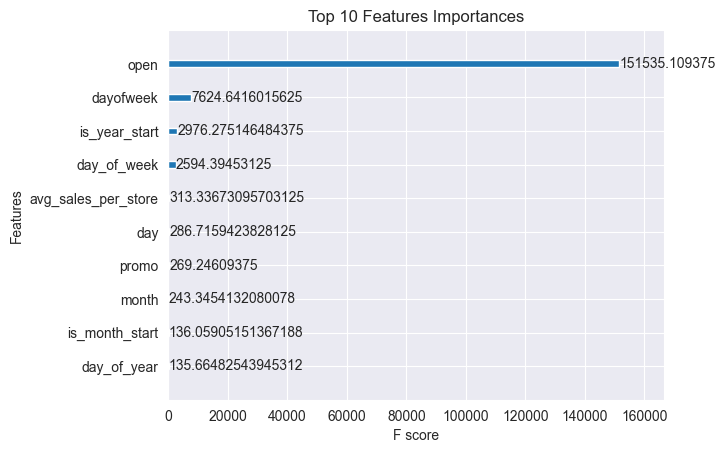

In [7]:
# graficar solo el top 10 de feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, max_num_features=10, importance_type='gain')  
plt.title('Top 10 Features Importances')
plt.show()

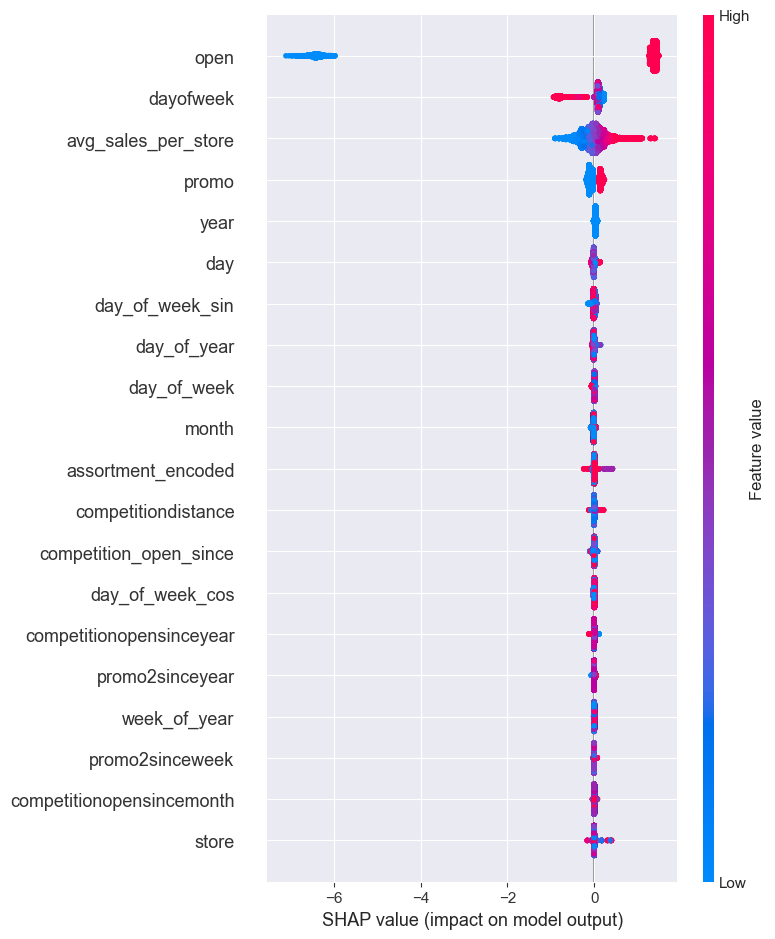

In [9]:
# crear el explainer de SHAP para XGBoost
explainer = shap.Explainer(best_model)

# obtener los valores SHAP
shap_values = explainer(X_test)

# resumen del feature importance
shap.summary_plot(shap_values, X_test)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

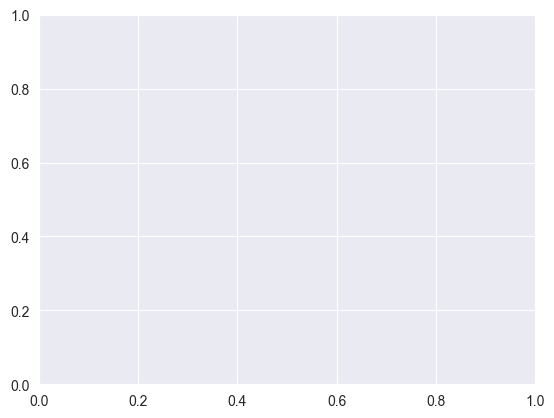

In [12]:
# visualizar el primer árbol del modelo
plot_tree(best_model, num_trees=0)
plt.show()